# 1. Imports, custom functions, etc.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import check_array

import os
import warnings
import pickle
import joblib
import optuna
import shutil
import glob
import json
import gc

warnings.filterwarnings("ignore")

In [2]:
class configs:

    train_path = "playground-series-s5e6/train.csv"
    test_path = "playground-series-s5e6/test.csv"
    original_path = "playground-series-s5e6/Fertilizer Prediction.csv"
    sample_sub_path = "playground-series-s5e6/sample_submission.csv"

    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

In [3]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [4]:
class Trainer:
    def __init__(self, model, config=configs):
        self.model = model
        self.config = config
        self.fitted_model = None  # Will hold the best model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        best_score = -np.inf  # For tracking the best fold model
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)

            if score > best_score:
                best_score = score
                self.fitted_model = model

            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        # Save the best model using joblib
        #if self.fitted_model is not None:
        #    model_name = self.fitted_model.__class__.__name__
        #    filename = f"best_model_{model_name}.pkl"
        #    joblib.dump(self.fitted_model, filename)
        #    print(f"✅ Best model saved to: {filename}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):
        scores = []
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

# 2. Load required datasets

In [5]:
# Load train & test data
train = pd.read_csv(configs.train_path, index_col="id")
test = pd.read_csv(configs.test_path, index_col="id")
original = pd.read_csv(configs.original_path)

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != "Fertilizer Name"]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

# Encode target "Fertilizer Name"
label_encoder = LabelEncoder()
train[configs.target] = label_encoder.fit_transform(train[configs.target])
original[configs.target] = label_encoder.transform(original[configs.target])

X = train.drop(configs.target, axis=1)
y = train[configs.target]
X_test = test

# 3. Load oof_preds & test_preds from previous

In [6]:
# Load OOF preds from .pkl
with open("oof_preds_full.pkl", "rb") as f:
    oof_pred_probs = pickle.load(f)

# Load Test preds from .pkl
with open("test_preds_full.pkl", "rb") as f:
    test_pred_probs = pickle.load(f)

# Validate dictionary keys of loaded predictions
print("Keys in oof_pred_probs:", list(oof_pred_probs.keys()))
print("Keys in test_pred_probs:", list(test_pred_probs.keys()))

# Validate shape of loaded precitions
print("\nShapes of OOF Predictions:")
for model_name, preds in oof_pred_probs.items():
    print(f"{model_name}: {preds.shape}")

print("\nShapes of Test Predictions:")
for model_name, preds in test_pred_probs.items():
    print(f"{model_name}: {preds.shape}")

Keys in oof_pred_probs: ['LightGBM (gbdt)', 'LightGBM (goss)', 'XGBoost', 'AutoGluon', 'TabTransformer']
Keys in test_pred_probs: ['LightGBM (gbdt)', 'LightGBM (goss)', 'XGBoost', 'AutoGluon', 'TabTransformer']

Shapes of OOF Predictions:
LightGBM (gbdt): (750000, 7)
LightGBM (goss): (750000, 7)
XGBoost: (750000, 7)
AutoGluon: (750000, 7)
TabTransformer: (750000, 7)

Shapes of Test Predictions:
LightGBM (gbdt): (250000, 7)
LightGBM (goss): (250000, 7)
XGBoost: (250000, 7)
AutoGluon: (250000, 7)
TabTransformer: (250000, 7)


In [7]:
scores = {}

models = ["LightGBM (gbdt)", "LightGBM (goss)", "XGBoost", "AutoGluon", "TabTransformer"]
model_keys = {
    "LightGBM (gbdt)": "LightGBM (gbdt)",
    "LightGBM (goss)": "LightGBM (goss)",
    "XGBoost": "XGBoost",
    "AutoGluon": "AutoGluon",
    "TabTransformer": "TabTransformer"
}

skf = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True)

for model in models:
    fold_scores = []
    preds = oof_pred_probs[model_keys[model]]
    
    for _, val_idx in skf.split(X, y):
        fold_score = map3(y[val_idx], preds[val_idx])
        fold_scores.append(fold_score)

    scores[model] = fold_scores

In [8]:
# Define training & testing sets from oof_pred_probs & test_pred_probs
X_ensemble = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_ensemble_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

# 4. Define Logistic Regression Model

In [9]:
lr_model = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    solver='liblinear', 
    penalty='l2', 
    C=32.89802104596641,
    tol=0.0029878837974181643,
    fit_intercept=True
)

lr_trainer = Trainer(lr_model)
_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X_ensemble, y, X_ensemble_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.366181
--- Fold 2 - MAP@3: 0.367057
--- Fold 3 - MAP@3: 0.369009
--- Fold 4 - MAP@3: 0.367234
--- Fold 5 - MAP@3: 0.367124

------ Overall MAP@3: 0.367321 | Average MAP@3: 0.367321 ± 0.000924


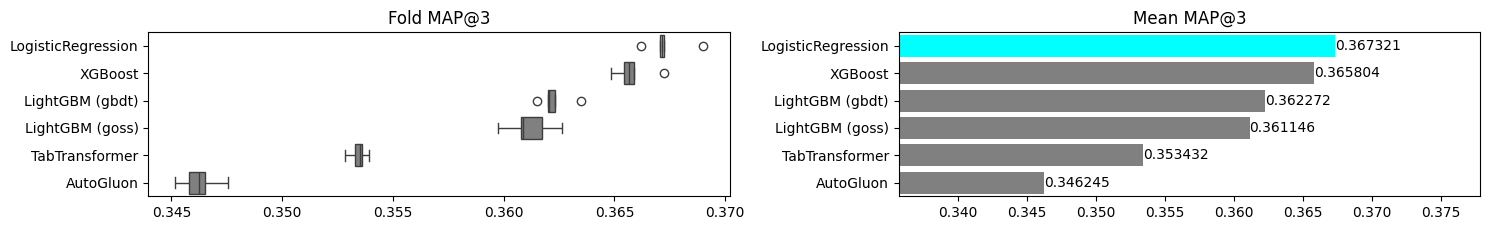

In [10]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

# 5. Compare Ensembling Techniques

## 5.1. Stacking Classifier

In [11]:
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]

estimators = [
    ('LightGBM (gbdt)', PassThroughClassifier(list(range(0, 7)))),
    ('LightGBM (goss)', PassThroughClassifier(list(range(7, 14)))),
    ('XGBoost', PassThroughClassifier(list(range(14, 21)))),
    ('AutoGluon', PassThroughClassifier(list(range(21, 28)))),
    ('TabTransformer', PassThroughClassifier(list(range(28, 35))))
]

In [12]:
stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1, final_estimator=clone(lr_model))
stacking_trainer = Trainer(stacking_model)

_, stacking_test_pred_probs, scores["StackingClassifier"] = stacking_trainer.fit_predict(X_ensemble, y, X_ensemble_test)

Training StackingClassifier

--- Fold 1 - MAP@3: 0.366181
--- Fold 2 - MAP@3: 0.367057
--- Fold 3 - MAP@3: 0.369009
--- Fold 4 - MAP@3: 0.367234
--- Fold 5 - MAP@3: 0.367124

------ Overall MAP@3: 0.367321 | Average MAP@3: 0.367321 ± 0.000924


## 5.2. Voting Classifier

In [13]:
voting_fold_scores = []
skf_voting = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True)

# Iterate through folds for voting, just like other models
for fold_idx, (train_idx, val_idx) in enumerate(skf_voting.split(X, y)): # Use X, y for indexing
    # Get OOF predictions for the current validation fold from each base model
    fold_oof_preds = []
    for model_name in models:
        fold_oof_preds.append(oof_pred_probs[model_name][val_idx])
    
    # Average the predictions for this fold
    avg_fold_preds = np.mean(fold_oof_preds, axis=0)
    
    # Calculate MAP@3 for this fold's voting ensemble
    fold_score = map3(y[val_idx], avg_fold_preds)
    voting_fold_scores.append(fold_score)
    print(f"--- Voting Fold {fold_idx + 1} - MAP@3: {fold_score:.6f}")

scores["VotingClassifier"] = voting_fold_scores

--- Voting Fold 1 - MAP@3: 0.365357
--- Voting Fold 2 - MAP@3: 0.366364
--- Voting Fold 3 - MAP@3: 0.367988
--- Voting Fold 4 - MAP@3: 0.366207
--- Voting Fold 5 - MAP@3: 0.366130


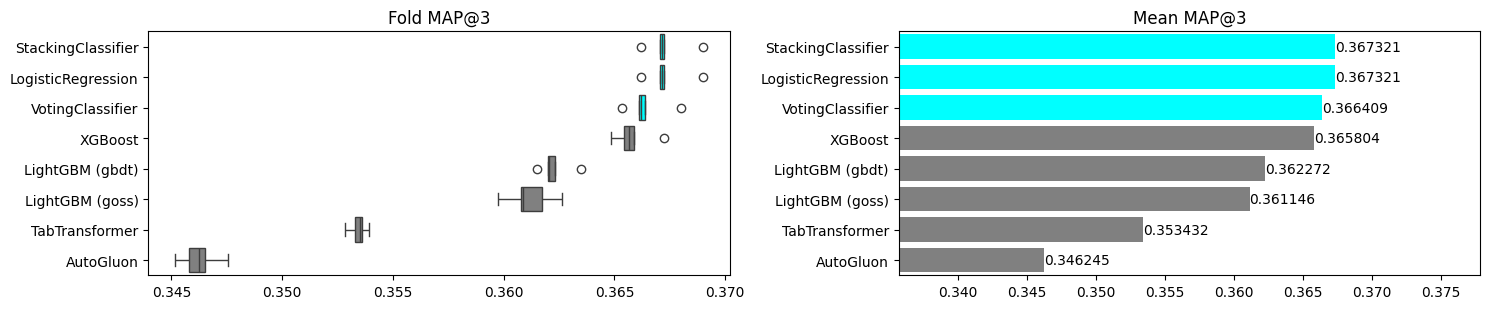


Shape of Final Voting Test Predictions: (250000, 7)


In [14]:
# Re-evaluate and plot all scores, including the voting ensemble
scores_df_final = pd.DataFrame(scores)
mean_scores_final = scores_df_final.mean().sort_values(ascending=False)
order_final = scores_df_final.mean().sort_values(ascending=False).index.tolist()

min_score_final = mean_scores_final.min()
max_score_final = mean_scores_final.max()
padding_final = (max_score_final - min_score_final) * 0.5
lower_limit_final = min_score_final - padding_final
upper_limit_final = max_score_final + padding_final

fig, axs = plt.subplots(1, 2, figsize=(15, scores_df_final.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores_df_final, order=order_final, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores_final.values, y=mean_scores_final.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit_final, right=upper_limit_final)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores_final.values, mean_scores_final.index)):
    color = "cyan" if "logistic" in model.lower() or "stacking" in model.lower() or "voting" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

# You can also compute the final test predictions for the voting ensemble:
final_voting_test_pred_probs = np.zeros_like(test_pred_probs[models[0]])
for model_name in models:
    final_voting_test_pred_probs += test_pred_probs[model_name]

final_voting_test_pred_probs /= len(models)
print("\nShape of Final Voting Test Predictions:", final_voting_test_pred_probs.shape)

## 5.3. Weighted Averaging

In [18]:
def objective(trial):
    weights = [trial.suggest_float(model_name, 0, 1) for model_name in models]
    # Normalize weights to sum to 1
    sum_weights = np.sum(weights)
    if sum_weights == 0: # Avoid division by zero if all weights are zero
        weights = np.ones_like(weights) / len(weights)
    else:
        weights /= sum_weights

    # Initialize prediction array
    # The shape should be (number of samples, number of classes), which is 7 classes.
    num_samples = oof_pred_probs[models[0]].shape[0]
    num_classes = oof_pred_probs[models[0]].shape[1]
    pred_probs = np.zeros((num_samples, num_classes))

    # Sum weighted predictions
    for i, model_name in enumerate(models):
        # Get the OOF predictions for the current model
        current_model_preds = oof_pred_probs[model_keys[model_name]]
        
        # Add to the total, applying the weight
        pred_probs += current_model_preds * weights[i]
        
    return map3(y, pred_probs) # y is your true labels

sampler = optuna.samplers.TPESampler(seed=configs.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)

# Print the best trial's information
print("\n--- Optuna Optimization Results ---")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.6f}")
print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Access the best weights
best_weights = [trial.params[model] for model in models]
best_weights_normalized = np.array(best_weights) / np.sum(best_weights)

print("\nBest Normalized Weights:")
for i, model_name in enumerate(models):
    print(f"  {model_name}: {best_weights_normalized[i]:.4f}")

# Calculate the final weighted test predictions using the best weights
final_weighted_test_pred_probs = np.zeros_like(test_pred_probs[models[0]])
for i, model_name in enumerate(models):
    final_weighted_test_pred_probs += test_pred_probs[model_name] * best_weights_normalized[i]

print("\nShape of Final Weighted Test Predictions:", final_weighted_test_pred_probs.shape)

[I 2025-06-15 17:36:22,965] A new study created in memory with name: no-name-a95eb745-193e-4772-8ae9-afa7dd46cdcc
[I 2025-06-15 17:36:30,799] Trial 3 finished with value: 0.3665106666666668 and parameters: {'LightGBM (gbdt)': 0.0827488386962848, 'LightGBM (goss)': 0.9701001171779432, 'XGBoost': 0.5326682755914256, 'AutoGluon': 0.15529496817773825, 'TabTransformer': 0.4249068331337833}. Best is trial 3 with value: 0.3665106666666668.
[I 2025-06-15 17:36:31,737] Trial 0 finished with value: 0.3671891111111112 and parameters: {'LightGBM (gbdt)': 0.8440460014009165, 'LightGBM (goss)': 0.2613862698786965, 'XGBoost': 0.8191466871069427, 'AutoGluon': 0.01723431411383225, 'TabTransformer': 0.49101742798480397}. Best is trial 0 with value: 0.3671891111111112.
[I 2025-06-15 17:36:32,276] Trial 2 finished with value: 0.366894 and parameters: {'LightGBM (gbdt)': 0.765372800519332, 'LightGBM (goss)': 0.7387199501755373, 'XGBoost': 0.9817910179835556, 'AutoGluon': 0.15442130777348917, 'TabTransforme


--- Optuna Optimization Results ---
Number of finished trials: 250
Best trial:
  Value: 0.367639
  Params: 
    LightGBM (gbdt): 0.05748492181668781
    LightGBM (goss): 0.14812860083161325
    XGBoost: 0.9765109614049066
    AutoGluon: 0.036380528903473264
    TabTransformer: 0.29117238156429326

Best Normalized Weights:
  LightGBM (gbdt): 0.0381
  LightGBM (goss): 0.0981
  XGBoost: 0.6468
  AutoGluon: 0.0241
  TabTransformer: 0.1929

Shape of Final Weighted Test Predictions: (250000, 7)


In [19]:
# Ensure 'CFG' is defined, likely 'configs' from your setup.
scores['WeightedEnsemble'] = [study.best_value] * configs.n_folds

# --- Apply Best Weights to Test Predictions ---
best_weights = [study.best_params[model_name] for model_name in models]

# Normalize weights to sum to 1
sum_best_weights = np.sum(best_weights)
if sum_best_weights == 0: # Handle case where all weights are zero (unlikely after successful optuna)
    best_weights_normalized = np.ones_like(best_weights) / len(best_weights)
else:
    best_weights_normalized = np.array(best_weights) / sum_best_weights

# Initialize array for weighted test predictions
# The shape should be (number of test samples, number of classes)
num_test_samples = test_pred_probs[models[0]].shape[0]
num_classes = test_pred_probs[models[0]].shape[1]
weighted_test_preds = np.zeros((num_test_samples, num_classes))

# Sum weighted test predictions from the dictionary of pre-computed test predictions
for i, model_name in enumerate(models):
    # Access the test predictions for the current model directly from the dictionary
    current_model_test_preds = test_pred_probs[model_keys[model_name]] # Use model_keys if names in dict differ from 'models' list directly
    
    # Add to the total, applying the normalized weight
    weighted_test_preds += current_model_test_preds * best_weights_normalized[i]

print(f"\nShape of Weighted Ensemble Test Predictions: {weighted_test_preds.shape}")


Shape of Weighted Ensemble Test Predictions: (250000, 7)


## 5.4. Weighted VotingClassifier


Optimized Normalized Weights for Ensemble:
  LightGBM (gbdt): 0.0381
  LightGBM (goss): 0.0981
  XGBoost: 0.6468
  AutoGluon: 0.0241
  TabTransformer: 0.1929
--- Weighted Ensemble Fold 1 - MAP@3: 0.366626
--- Weighted Ensemble Fold 2 - MAP@3: 0.367033
--- Weighted Ensemble Fold 3 - MAP@3: 0.369068
--- Weighted Ensemble Fold 4 - MAP@3: 0.367714
--- Weighted Ensemble Fold 5 - MAP@3: 0.367753

Shape of Weighted Voting Ensemble Test Predictions: (250000, 7)


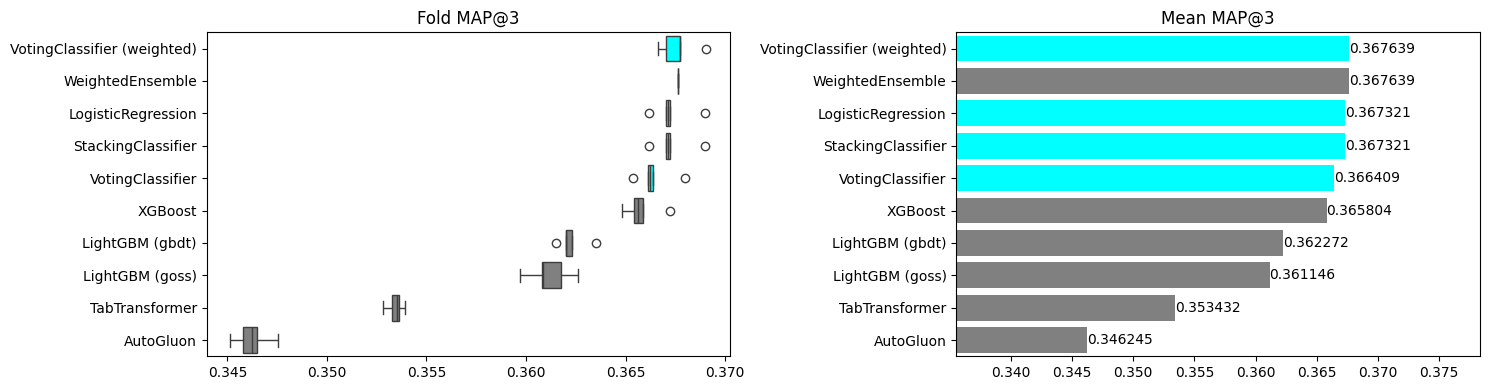

In [21]:
# Retrieve the best weights from Optuna study
best_weights_optuna = [study.best_params[model_name] for model_name in models]

# Normalize the best weights
sum_best_weights_optuna = np.sum(best_weights_optuna)
if sum_best_weights_optuna == 0:
    # Handle case where all weights are zero, unlikely after Optuna
    best_weights_normalized_optuna = np.ones_like(best_weights_optuna) / len(best_weights_optuna)
else:
    best_weights_normalized_optuna = np.array(best_weights_optuna) / sum_best_weights_optuna

print("\nOptimized Normalized Weights for Ensemble:")
for i, model_name in enumerate(models):
    print(f"  {model_name}: {best_weights_normalized_optuna[i]:.4f}")

# --- Calculate Fold-wise MAP@3 for Weighted Ensemble (OOF) ---
weighted_ensemble_fold_scores = []
skf_weighted = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True)

for fold_idx, (train_idx, val_idx) in enumerate(skf_weighted.split(X, y)): # Use X, y for indexing folds
    # Initialize weighted predictions for the current validation fold
    current_fold_weighted_oof_preds = np.zeros_like(oof_pred_probs[models[0]][val_idx])

    # Apply weighted average to OOF predictions for this fold
    for i, model_name in enumerate(models):
        current_fold_oof_preds = oof_pred_probs[model_keys[model_name]][val_idx]
        current_fold_weighted_oof_preds += current_fold_oof_preds * best_weights_normalized_optuna[i]
    
    # Calculate MAP@3 for this fold
    fold_score = map3(y[val_idx], current_fold_weighted_oof_preds)
    weighted_ensemble_fold_scores.append(fold_score)
    print(f"--- Weighted Ensemble Fold {fold_idx + 1} - MAP@3: {fold_score:.6f}")

# Add the weighted ensemble scores to your 'scores' dictionary
scores["VotingClassifier (weighted)"] = weighted_ensemble_fold_scores

# --- Calculate Weighted Ensemble Test Predictions ---
# Initialize weighted predictions for the test set
weighted_voting_test_pred_probs = np.zeros_like(test_pred_probs[models[0]])

# Apply weighted average to test predictions
for i, model_name in enumerate(models):
    current_model_test_preds = test_pred_probs[model_keys[model_name]]
    weighted_voting_test_pred_probs += current_model_test_preds * best_weights_normalized_optuna[i]

print(f"\nShape of Weighted Voting Ensemble Test Predictions: {weighted_voting_test_pred_probs.shape}")

# Optional: Re-plot all scores including the new weighted ensemble
scores_df_final = pd.DataFrame(scores)
mean_scores_final = scores_df_final.mean().sort_values(ascending=False)
order_final = scores_df_final.mean().sort_values(ascending=False).index.tolist()

min_score_final = mean_scores_final.min()
max_score_final = mean_scores_final.max()
padding_final = (max_score_final - min_score_final) * 0.5
lower_limit_final = min_score_final - padding_final
upper_limit_final = max_score_final + padding_final

fig, axs = plt.subplots(1, 2, figsize=(15, scores_df_final.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores_df_final, order=order_final, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores_final.values, y=mean_scores_final.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit_final, right=upper_limit_final)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores_final.values, mean_scores_final.index)):
    color = "cyan" if "logistic" in model.lower() or "stacking" in model.lower() or "voting" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [24]:
# --- Re-confirm best weights and calculate final weighted_test_preds ---
# Retrieve the best weights from Optuna study
best_weights_optuna = [study.best_params[model_name] for model_name in models]

# Normalize the best weights
sum_best_weights_optuna = np.sum(best_weights_optuna)
if sum_best_weights_optuna == 0:
    best_weights_normalized_optuna = np.ones_like(best_weights_optuna) / len(best_weights_optuna)
else:
    best_weights_normalized_optuna = np.array(best_weights_optuna) / sum_best_weights_optuna

print("\nOptimized Normalized Weights for Ensemble:")
for i, model_name in enumerate(models):
    print(f"  {model_name}: {best_weights_normalized_optuna[i]:.4f}")

# Calculate Weighted Ensemble Test Predictions
weighted_voting_test_pred_probs = np.zeros_like(test_pred_probs[models[0]])
for i, model_name in enumerate(models):
    current_model_test_preds = test_pred_probs[model_keys[model_name]]
    weighted_voting_test_pred_probs += current_model_test_preds * best_weights_normalized_optuna[i]

print(f"\nShape of Final Weighted Voting Ensemble Test Predictions: {weighted_voting_test_pred_probs.shape}")

# Get the average score for the weighted ensemble from the 'scores' dictionary
# This should be the same as study.best_value
weighted_ensemble_avg_score = np.mean(scores["VotingClassifier (weighted)"])
print(f"Average MAP@3 for Weighted Ensemble: {weighted_ensemble_avg_score:.6f}")


Optimized Normalized Weights for Ensemble:
  LightGBM (gbdt): 0.0381
  LightGBM (goss): 0.0981
  XGBoost: 0.6468
  AutoGluon: 0.0241
  TabTransformer: 0.1929

Shape of Final Weighted Voting Ensemble Test Predictions: (250000, 7)
Average MAP@3 for Weighted Ensemble: 0.367639


In [26]:
# Define create_submission function (re-iterated for clarity in this block)
def create_submission(model_name_for_file, test_pred_probs_for_submission, avg_score_for_file):
    """
    Generates a submission DataFrame and saves it to a CSV file.

    Args:
        model_name_for_file (str): Name of the model for the submission file.
        test_pred_probs_for_submission (np.ndarray): Predicted probabilities for the test set from the best model.
        avg_score_for_file (float): Average score of the best model.

    Returns:
        pd.DataFrame: The head of the submission DataFrame.
    """
    # Inverse transform the numerical predictions back to original fertilizer names
    top3_indices = np.argsort(test_pred_probs_for_submission, axis=1)[:, ::-1][:, :3]
    top3_labels = label_encoder.inverse_transform(top3_indices.flatten()).reshape(-1, 3)
    predictions_str = [' '.join(row) for row in top3_labels]

    submission_df = pd.DataFrame({
        'id': test.index,
        'Fertilizer Name': predictions_str
    })

    submission_dir = "submissions"
    os.makedirs(submission_dir, exist_ok=True)

    sanitized_model_name = model_name_for_file.replace(" ", "_").replace("(", "").replace(")", "").replace(".", "")
    filename = os.path.join(submission_dir, f"{sanitized_model_name}_MAP3_{avg_score_for_file:.6f}.csv")
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved to: {filename}")
    
    return submission_df.head()

# --- GENERATE SUBMISSION FOR THE BEST MODEL ---
# Based on your plot, "Weighted Ensemble" (or "VotingClassifier (weighted)") is the best.
# We will use 'weighted_voting_test_pred_probs' as it holds the final predictions
# from this best model and 'weighted_ensemble_avg_score' for the score in the filename.

print("\n--- Generating Submission for the Best Model ---")
submission_head = create_submission(
    "WeightedEnsemble", # A clear name for the submission file
    weighted_voting_test_pred_probs,
    weighted_ensemble_avg_score
)

print("\nSubmission DataFrame Head:")
print(submission_head)


--- Generating Submission for the Best Model ---
Submission file saved to: submissions\WeightedEnsemble_MAP3_0.367639.csv

Submission DataFrame Head:
       id          Fertilizer Name
0  750000       10-26-26 DAP 20-20
1  750001  17-17-17 10-26-26 20-20
2  750002         20-20 28-28 Urea
3  750003    14-35-14 DAP 17-17-17
4  750004      20-20 Urea 10-26-26
